## HYBRID MONTE CARLO SAMPLING -- BIVARIATE NORMAL

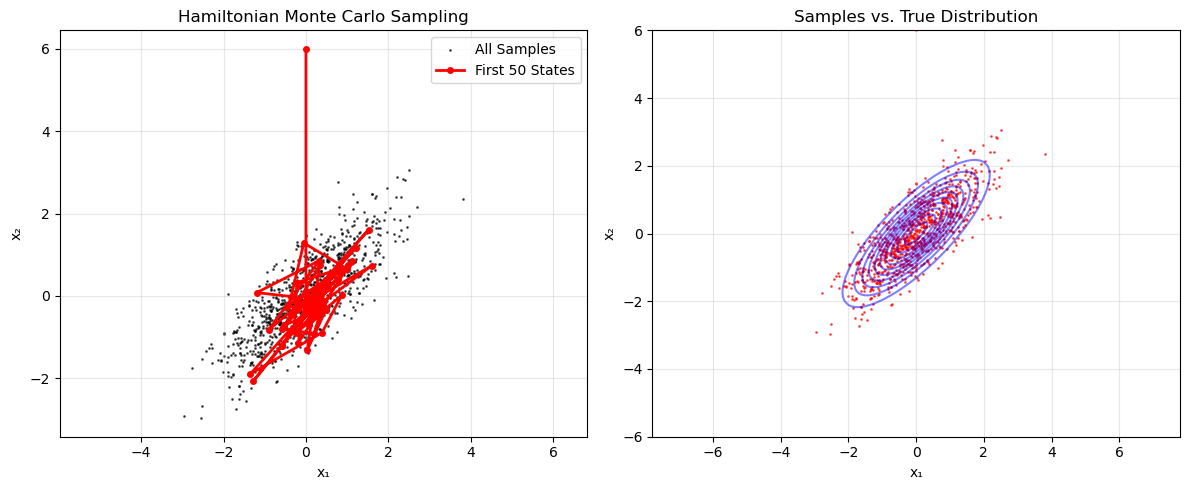

Number of samples: 1000
Acceptance rate: 0.967
Sample mean: [-0.013, -0.006]
Sample covariance matrix:
[[0.96473284 0.75573096]
 [0.75573096 0.98052094]]
True covariance matrix:
[[1.  0.8]
 [0.8 1. ]]


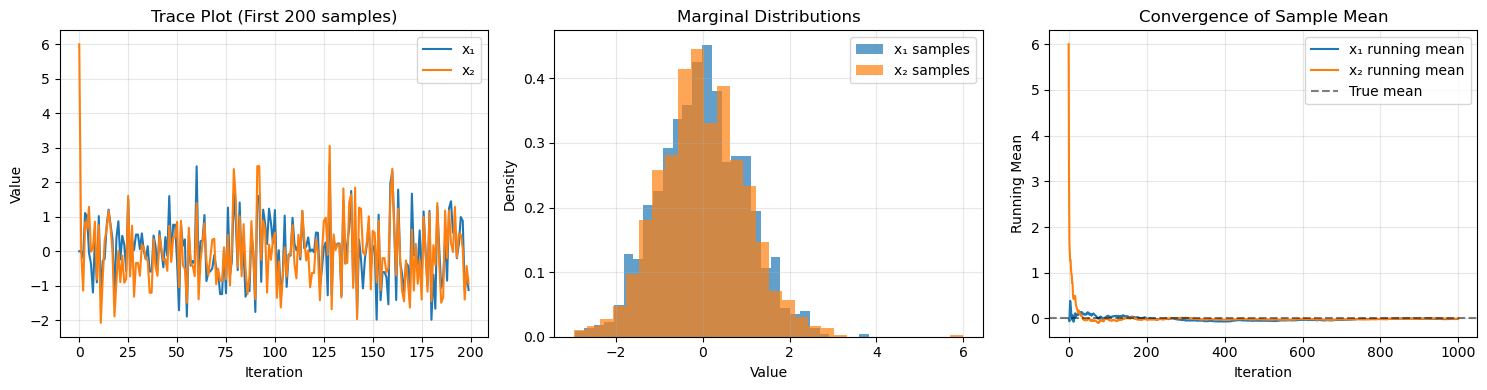

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

# Set random seeds for reproducibility
np.random.seed(1)#956)

# STEP SIZE
delta = 0.3
nSamples = 1000#0
L = 20

# Define the covariance matrix and its inverse
cov_matrix = np.array([[1, 0.8], [0.8, 1]])
inv_cov = inv(cov_matrix)

# DEFINE POTENTIAL ENERGY FUNCTION
def U(x):
    """Potential energy function for bivariate normal"""
    return 0.5 * x.T @ inv_cov @ x

# DEFINE GRADIENT OF POTENTIAL ENERGY
def dU(x):
    """Gradient of potential energy"""
    return inv_cov @ x

# DEFINE KINETIC ENERGY FUNCTION
def K(p):
    """Kinetic energy function"""
    return np.sum(p.T @ p) / 2

# INITIAL STATE
x = np.zeros((2, nSamples))
x0 = np.array([0, 6])
x[:, 0] = x0

# Hamiltonian Monte Carlo sampling
t = 1
n_accepted = 0

while t < nSamples-1:
    t += 1
    # SAMPLE RANDOM MOMENTUM
    p0 = np.random.randn(2)    
    ## SIMULATE HAMILTONIAN DYNAMICS
    # FIRST 1/2 STEP OF MOMENTUM
    pStar = p0 - delta/2 * dU(x[:, t-1])   
    # FIRST FULL STEP FOR POSITION/SAMPLE
    xStar = x[:, t-1] + delta * pStar    
    # FULL STEPS
    for jL in range(L-1):
        # MOMENTUM
        pStar = pStar - delta * dU(xStar)
        # POSITION/SAMPLE
        xStar = xStar + delta * pStar    
    # LAST HALF STEP
    pStar = pStar - delta/2 * dU(xStar)    
    # COULD NEGATE MOMENTUM HERE TO LEAVE
    # THE PROPOSAL DISTRIBUTION SYMMETRIC.
    # HOWEVER WE THROW THIS AWAY FOR NEXT
    # SAMPLE, SO IT DOESN'T MATTER
    
    # EVALUATE ENERGIES AT
    # START AND END OF TRAJECTORY
    U0 = U(x[:, t-1])
    UStar = U(xStar)
    
    K0 = K(p0)
    KStar = K(pStar)
    
    # Metropolis ACCEPTANCE/REJECTION CRITERION
    alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))
    
    u = np.random.rand()
    if u < alpha:
        x[:, t] = xStar
        n_accepted += 1
    else:
        x[:, t] = x[:, t-1]
    
# Calculate acceptance rate
acceptance_rate = n_accepted / (nSamples - 1)

# DISPLAY RESULTS
plt.figure(figsize=(12, 5))

# Plot 1: Scatter plot of all samples
plt.subplot(1, 2, 1)
plt.scatter(x[0, :], x[1, :], c='black', s=1, alpha=0.6, label='All Samples')
plt.plot(x[0, :50], x[1, :50], 'ro-', linewidth=2, markersize=4, label='First 50 States')
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.legend()
plt.title('Hamiltonian Monte Carlo Sampling')
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 2: Add theoretical contours for comparison
plt.subplot(1, 2, 2)
# Create grid for contour plot
x1_range = np.linspace(-6, 6, 100)
x2_range = np.linspace(-6, 6, 100)
X1, X2 = np.meshgrid(x1_range, x2_range)

# Calculate the bivariate normal density
det_cov = np.linalg.det(cov_matrix)
density = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        x_vec = np.array([X1[i, j], X2[i, j]])
        density[i, j] = np.exp(-0.5 * x_vec.T @ inv_cov @ x_vec) / (2 * np.pi * np.sqrt(det_cov))

# Plot contours and samples
plt.contour(X1, X2, density, levels=10, colors='blue', alpha=0.5)
plt.scatter(x[0, :], x[1, :], c='red', s=1, alpha=0.6)
plt.xlim([-6, 6])
plt.ylim([-6, 6])
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Samples vs. True Distribution')
plt.grid(True, alpha=0.3)
plt.axis('equal')

plt.tight_layout()
plt.show()

# Print statistics
print(f"Number of samples: {nSamples}")
print(f"Acceptance rate: {acceptance_rate:.3f}")
print(f"Sample mean: [{np.mean(x[0, :]):.3f}, {np.mean(x[1, :]):.3f}]")
print(f"Sample covariance matrix:")
print(np.cov(x))
print(f"True covariance matrix:")
print(cov_matrix)

# Additional diagnostic plots
plt.figure(figsize=(15, 4))

# Trace plots
plt.subplot(1, 3, 1)
plt.plot(x[0, :200], label='x₁')
plt.plot(x[1, :200], label='x₂')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Trace Plot (First 200 samples)')
plt.legend()
plt.grid(True, alpha=0.3)

# Marginal distributions
plt.subplot(1, 3, 2)
plt.hist(x[0, :], bins=30, alpha=0.7, density=True, label='x₁ samples')
plt.hist(x[1, :], bins=30, alpha=0.7, density=True, label='x₂ samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Marginal Distributions')
plt.legend()
plt.grid(True, alpha=0.3)

# Running mean
plt.subplot(1, 3, 3)
running_mean_x1 = np.cumsum(x[0, :]) / np.arange(1, nSamples + 1)
running_mean_x2 = np.cumsum(x[1, :]) / np.arange(1, nSamples + 1)
plt.plot(running_mean_x1, label='x₁ running mean')
plt.plot(running_mean_x2, label='x₂ running mean')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5, label='True mean')
plt.xlabel('Iteration')
plt.ylabel('Running Mean')
plt.title('Convergence of Sample Mean')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()